In [2]:
# SET UP: this cell imports libraries and mounts GDrive
!pip install swifter
!pip install torch
!pip install spacy
!pip install seaborn

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import spacy
from collections import Counter
import re
import string
import math
from torch.optim import lr_scheduler
import swifter
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sns 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# download spacy en model
!python -m spacy download en

2021-05-07 01:39:01.978871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.7 MB 4.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Hiyori


## Get Data

In [4]:
# read CSV
df_train = pd.read_csv('/content/drive/MyDrive/CIS530-project/train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/CIS530-project/dev.csv')
df_test = pd.read_csv('/content/drive/MyDrive/CIS530-project/test.csv')

## Preprocessing

In [5]:
# remove punctuation, special characters, lower case text and perform tokenization
tok = spacy.load('en_core_web_sm')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [6]:
# method to apply tokenize function and find number of words of each Tweet
def apply_tokenize_and_length(df):
    df['text'].swifter.apply(lambda x: counts.update(tokenize(x)))
    df['length'] = df['text'].swifter.apply(lambda x: len(x.split(' ')))

In [7]:
# count number of occurrences of each token in corpus
counts = Counter()
apply_tokenize_and_length(df_train)
apply_tokenize_and_length(df_val)
apply_tokenize_and_length(df_test)

Pandas Apply:   0%|          | 0/195415 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/195415 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24177 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24177 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24338 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24338 [00:00<?, ?it/s]

In [8]:
avg_length = np.mean([np.mean(df_train['length']), np.mean(df_val['length']), np.mean(df_test['length'])])
avg_length

22.57685314600808

In [9]:
# remove very infrequent (occurs less than twice) words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 33227
num_words after: 31121


In [10]:
# create vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [11]:
# make max length celing(avg_length * 1.5)
def encode_sentence(text, vocab2index, N=math.ceil(avg_length*1.5)):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [12]:
# add encoded column in dataframe
df_train['encoded'] = df_train['text'].swifter.apply(lambda x: np.array(encode_sentence(x,vocab2index )))
df_val['encoded'] = df_val['text'].swifter.apply(lambda x: np.array(encode_sentence(x,vocab2index )))
df_test['encoded'] = df_test['text'].swifter.apply(lambda x: np.array(encode_sentence(x,vocab2index )))

Pandas Apply:   0%|          | 0/195415 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Pandas Apply:   0%|          | 0/24177 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


Pandas Apply:   0%|          | 0/24338 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [13]:
# replace sentiment strings with negative=0, neutral=1, positive=2
sentiment_numbering = {'negative':0, 'neutral':1, 'positive':2}
df_train['sentiment'] = df_train['sentiment'].apply(lambda x: sentiment_numbering[x])
df_val['sentiment'] = df_val['sentiment'].apply(lambda x: sentiment_numbering[x])
df_test['sentiment'] = df_test['sentiment'].apply(lambda x: sentiment_numbering[x])

# Create Dataset and Dataloaders

In [14]:
# Tweet Dataset class
class TweetDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [15]:
# Make train, dev, and test X and y vectors
X_train = list(df_train['encoded'])
y_train = list(df_train['sentiment'])
X_dev = list(df_val['encoded'])
y_dev = list(df_val['sentiment'])
X_test = list(df_test['encoded'])
y_test = list(df_test['sentiment'])

In [16]:
# Create TweetDatasets for train, validation, and test
train_ds = TweetDataset(X_train, y_train)
valid_ds = TweetDataset(X_dev, y_dev)
test_ds = TweetDataset(X_test, y_test)

In [17]:
# Set batch size and vocab size; Create the dataloaders
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size)
val_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

## Training and Validation Methods

In [18]:
# variables for saving the model 
model_save_name = 'lstm_test.pt'
model_saved_path = F"/{model_save_name}" 
# torch.save(model.state_dict(), model_saved_path)

In [19]:
# Train method
def train_model(model, train_dl, val_dl, optimizer, criterion, scheduler, epochs=30):
    train_losses = []
    train_accs = []
    val_losses =[]
    val_accs = []
    train_final_preds = []
    train_actuals = [] 
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        correct = 0 
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            pred = torch.max(y_pred, 1)[1]
            correct += (pred == y).float().sum()
            total += y.shape[0]
            sum_loss += loss.item()*y.shape[0]
            if i == epochs-1:
                # if last epoch, save preds and actual so same order 
                train_final_preds.extend(pred.tolist())
                train_actuals.extend(y.tolist())
        scheduler.step()
        train_losses.append(sum_loss/total)
        train_accs.append((correct/total).item())
        if i == epochs-1:
            val_loss, val_acc, val_final_preds, val_actuals = validation_metrics(model, val_dl, criterion, True)
        else: 
            val_loss, val_acc = validation_metrics(model, val_dl, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())
        torch.save(model.state_dict(), model_saved_path)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
    return train_losses, train_accs, val_losses, val_accs, train_final_preds, train_actuals, val_final_preds, val_actuals 

# Method to obtain validation metrics
def validation_metrics (model, valid_dl, criterion, get_preds_actuals = False):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    final_preds = [] 
    actuals = []
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = criterion(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        if get_preds_actuals:
            final_preds.extend(pred.tolist())
            actuals.extend(y.tolist())
    if get_preds_actuals:
        return sum_loss/total, correct/total, final_preds, actuals
    else:
        return sum_loss/total, correct/total

## LSTM with pretrained Glove word embeddings

In [20]:
# load glove vectors
def load_glove_vectors(glove_file="/content/drive/MyDrive/CIS530-project/glove.6B.50d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [21]:
# get embedding matrix for words in our dataset
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [22]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [23]:
# LSTM model
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [25]:
model = LSTM_glove_vecs(vocab_size, 50, 50, pretrained_weights)

In [26]:
# set hyperparameters
lr = 0.1
step_size = 5
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

In [31]:
# To load pre-trained (own) model
# model.load_state_dict(torch.load("/tf/lstm_step_5.pt"))

<All keys matched successfully>

## Train

In [27]:
train_losses_all = []
train_accs_all = []
val_losses_all = []
val_accs_all = []

In [29]:
train_losses, train_accs, val_losses, val_accs, train_final_preds, train_actuals, val_final_preds, val_actuals = train_model(model, train_dl, val_dl, optimizer, criterion, scheduler, 30)

train loss 0.827, val loss 0.788, val accuracy 0.673


In [248]:
train_losses_all.extend(train_losses)
train_accs_all.extend(train_accs)
val_losses_all.extend(val_losses)
val_accs_all.extend(val_accs)

In [249]:
train_losses, train_accs, val_losses, val_accs, train_final_preds, train_actuals, val_final_preds, val_actuals = train_model(model, train_dl, val_dl, optimizer, criterion, scheduler, 30)

train loss 0.986, val loss 0.970, val accuracy 0.564
train loss 0.986, val loss 0.970, val accuracy 0.564
train loss 0.985, val loss 0.970, val accuracy 0.564
train loss 0.985, val loss 0.970, val accuracy 0.564
train loss 0.985, val loss 0.970, val accuracy 0.564
train loss 0.986, val loss 0.970, val accuracy 0.564


In [250]:
train_losses_all.extend(train_losses)
train_accs_all.extend(train_accs)
val_losses_all.extend(val_losses)
val_accs_all.extend(val_accs)

In [251]:
train_losses, train_accs, val_losses, val_accs, train_final_preds, train_actuals, val_final_preds, val_actuals = train_model(model, train_dl, val_dl, optimizer, criterion, scheduler, 30)

train loss 0.986, val loss 0.970, val accuracy 0.564
train loss 0.985, val loss 0.970, val accuracy 0.564
train loss 0.985, val loss 0.970, val accuracy 0.564
train loss 0.985, val loss 0.970, val accuracy 0.564
train loss 0.985, val loss 0.970, val accuracy 0.564
train loss 0.985, val loss 0.970, val accuracy 0.564


In [252]:
train_losses_all.extend(train_losses)
train_accs_all.extend(train_accs)
val_losses_all.extend(val_losses)
val_accs_all.extend(val_accs)

In [30]:
# Create dataframes of the predictions and gold labels
df_train_pred = pd.DataFrame(train_final_preds)
df_train_actual = pd.DataFrame(train_actuals)
df_val_pred = pd.DataFrame(val_final_preds)
df_val_actual = pd.DataFrame(val_actuals)

In [31]:
# Method to plot loss and accuracy training curves
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

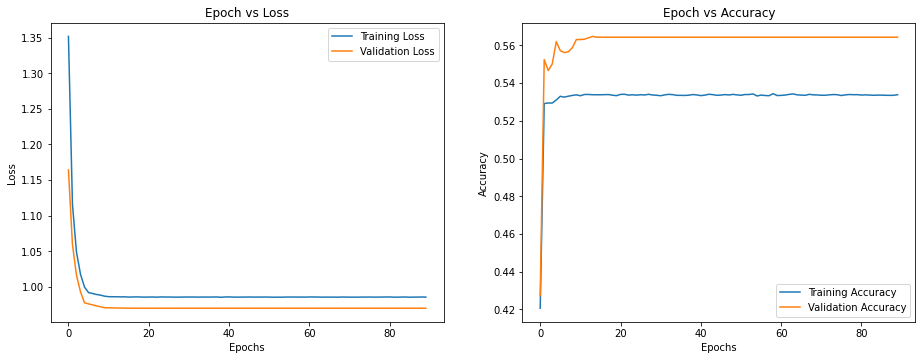

In [255]:
plot_loss_accuracy(train_losses_all, train_accs_all, val_losses_all, val_accs_all)

## Confusion Matrix

In [32]:
# Plots confusion matrix using preds and actuals lists
def plot_confusion_matrix(classes_list, preds, actual):
    num_classes = len(classes_list)
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for actual_class, pred_class in zip(actual, preds):
        confusion_matrix[actual_class, pred_class] += 1
    
    #normalize
    for i in range(num_classes):
        row_sum = torch.sum(confusion_matrix[i]) 
        if row_sum:
            confusion_matrix[i] = confusion_matrix[i] / row_sum
                            
    df_cm = pd.DataFrame(confusion_matrix.tolist(), index = classes_list,
                      columns = classes_list)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)

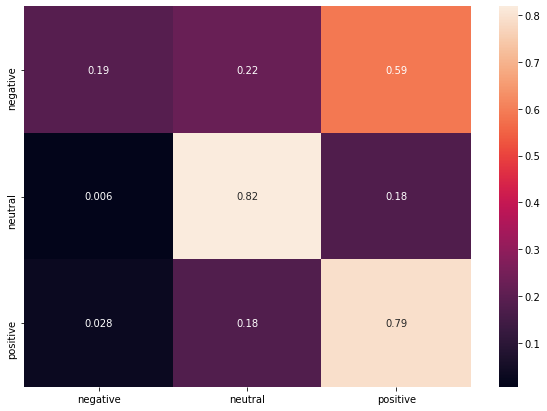

In [33]:
classes_list = ['negative', 'neutral', 'positive']
plot_confusion_matrix(classes_list, val_final_preds, val_actuals)

## Inference on Test Set

In [34]:
test_loss, test_acc, test_final_preds, test_actuals = validation_metrics(model, test_dl, criterion, True)

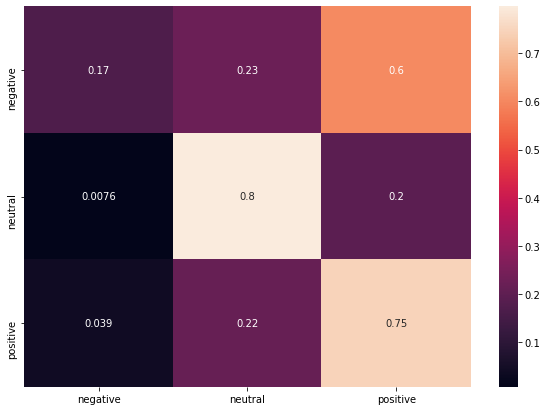

In [35]:
plot_confusion_matrix(classes_list, test_final_preds, test_actuals)

In [36]:
df_test_pred = pd.DataFrame(test_final_preds)
df_test_actual = pd.DataFrame(test_actuals)

In [37]:
df_test_actual.head()

,0
0,2
1,1
2,1
3,0
4,1


In [261]:
# Method to save all prediction and gold label csvs
def dfs_to_csv(dfs, csv_names):
    for df, name in zip(dfs, csv_names):
        df.to_csv(name, index=False)

In [262]:
dfs = [df_train_pred, df_train_actual, df_val_pred, df_val_actual, df_test_pred, df_test_actual]
csv_names = ['df_train_pred.csv', 'df_train_actual.csv', 'df_val_pred.csv', 'df_val_actual.csv', 'df_test_pred.csv', 'df_test_actual.csv']

In [263]:
dfs_to_csv(dfs, csv_names)